# Calibration of the flooding model with nonlinear least squares

The goal of this example is to calibrate the simulator associated with the flooding model with nonlinear least squares.

In [1]:
import openturns as ot
import numpy as np
import CalibrationGraphics as cg

## Read the observations

We begin by reading the observations from the data file. There are 100 observations of the couple (Q,H).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calibration_flooding_observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Height (m)"])

## Define the model

We define the model which has 4 inputs and one output H.

The nonlinear least squares does not take into account for bounds in the parameters. Therefore, we ensure that the output is computed whatever the inputs. The model fails into two situations:

* if $K_s<0$,
* if $Z_v-Z_m<0$.

In these cases, we return an infinite number, so that the optimization algorithm does not get trapped.

In [4]:
np.inf

inf

In [5]:
def functionFloodingModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    if alpha < 0.0 or K_s <= 0.0:
        return [np.inf]
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [6]:
modelPyFunc = ot.PythonFunction(4, 1, functionFloodingModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [7]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaPrior = ot.Point([KsInitial,ZvInitial,ZmInitial])
thetaPrior.setDescription(("Ks","Zv","Zm"))

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [8]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaPrior)

## Calibration

Defined the covariance matrix of the parameters $\theta$ to calibrate.

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [9]:
algo = ot.NonLinearLeastSquaresCalibration(mycf, Qobs, Hobs, thetaPrior)

The `run` method computes the solution of the problem.

In [10]:
algo.run()

In [11]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [12]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[22.9822,51.6199,60.2265]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

This confidence interval is based on bootstrap, based on a sample size equal to 100 (as long as the value of the ResourceMap key "NonLinearLeastSquaresCalibration-BootstrapSize" is unchanged). This confidence interval reflects the sensitivity of the optimum to the random observations.

In [13]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[22.0258,45.9003,54.4144] upper bound=class=Point name=Unnamed dimension=3 values=[25.2585,54.0202,62.1041] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

In this case, the value of the parameter $K_s$ is quite accurately computed, but there is a relatively large uncertainty on the values of $Z_v$ and $Z_m$.

In [14]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[-0.00455259] sigma=class=Point name=Unnamed dimension=1 values=[0.100677] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

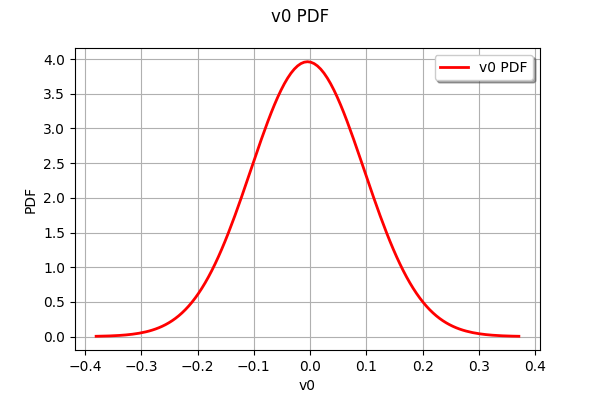

In [15]:
observationError.drawPDF()

We can see that the observation error is close to have a zero mean and a standard deviation equal to 0.1.

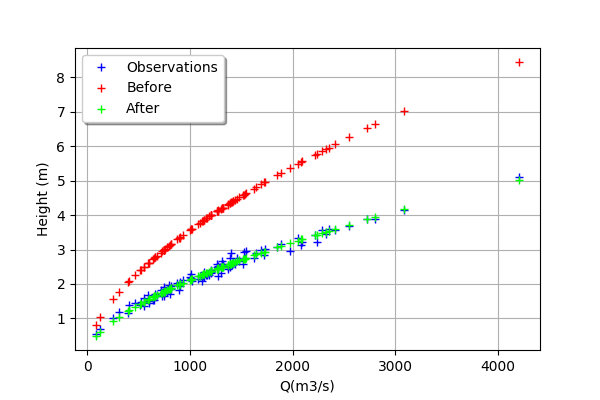

In [16]:
graph = cg.drawModelVsObservationsBeforeAndAFter(thetaPrior,thetaMAP,Qobs,Hobs,mycf)
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

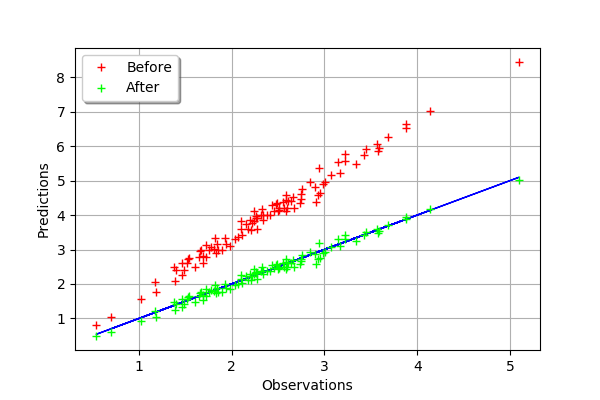

In [18]:
cg.drawObservationsVsPredictionsBeforeAfter(thetaPrior,thetaMAP,Qobs,Hobs,mycf)

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

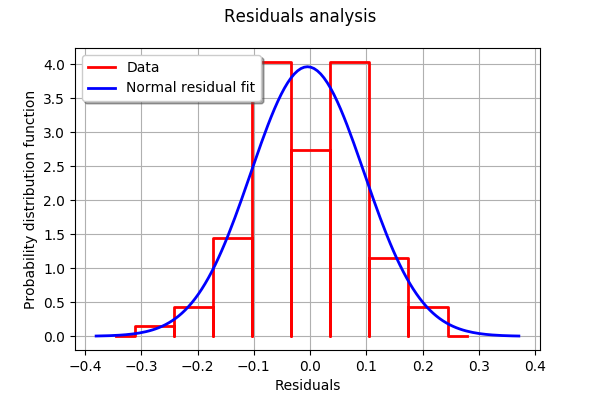

In [19]:
graph = cg.drawResiduals(thetaMAP,Qobs,Hobs,mycf)
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. This indicates that the observation error might be gaussian.

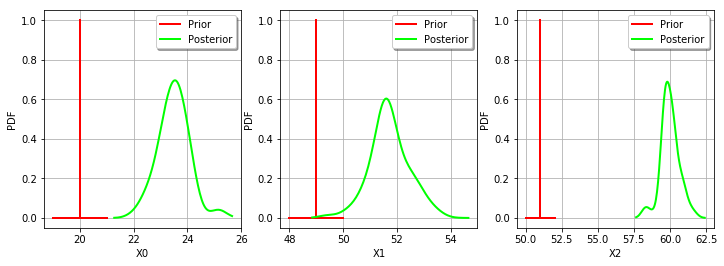

In [20]:
_ = cg.drawThetaDistribution(calibrationResult)